In [ ]:
import os
import tensorflow as tf

# ---- config ----
width = 128
height = 128
IMG_SIZE = (width, height)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Point this to your folder that contains images
# Example: "/content/celeba/img_align_celeba"
DATA_DIR = "./img_align_celeba"  # <-- change this

# ---- list image files (supports jpg/jpeg/png) ----
patterns = [
    os.path.join(DATA_DIR, "*.jpg"),
    os.path.join(DATA_DIR, "*.jpeg"),
    os.path.join(DATA_DIR, "*.png"),
]
files = []
for p in patterns:
    files.extend(tf.io.gfile.glob(p))

if len(files) == 0:
    raise ValueError(f"No images found in: {DATA_DIR}")

print("Total images found:", len(files))

2025-12-21 11:51:04.460841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 11:51:05.018498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/l

ValueError: No images found in: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba

In [2]:
import random

# MAX_IMAGES = 20000
# SEED = 42

# random.seed(SEED)
# random.shuffle(files)
# files = files[:MAX_IMAGES]

# print("Using images:", len(files))

In [3]:
# ---- split into train/val/test by file list (small, RAM-safe) ----
tf.random.set_seed(42)
files = tf.random.shuffle(files)

N = tf.shape(files)[0]
n_train = tf.cast(tf.cast(N, tf.float32) * 0.8, tf.int32)
n_val   = tf.cast(tf.cast(N, tf.float32) * 0.1, tf.int32)

train_files = files[:n_train]
val_files   = files[n_train:n_train + n_val]
test_files  = files[n_train + n_val:]

print(
    "Train:", len(train_files),
    "Val:",   len(val_files),
    "Test:",  len(test_files)
)

Train: 162079 Val: 20259 Test: 20261


I0000 00:00:1765630033.584447      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765630033.585109      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# ---- decode/resize/normalize + build (X_gray, Y_rgb) ----
def load_make_xy(path):
    # Read bytes
    img_bytes = tf.io.read_file(path)

    # Decode (channels=3 forces RGB)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])

    # Resize to model size
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")

    # Convert to float in [0,1]
    y_rgb = tf.clip_by_value(tf.cast(img, tf.float32) / 255.0, 0.0, 1.0)

    # Create grayscale input (keep dims -> (64,64,1))
    x_gray = tf.image.rgb_to_grayscale(y_rgb)

    return x_gray, y_rgb


def make_ds(file_list, training=False):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    if training:
        ds = ds.shuffle(buffer_size=10_000, reshuffle_each_iteration=True)
    ds = ds.map(load_make_xy, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


train_ds = make_ds(train_files, training=True)
val_ds   = make_ds(val_files, training=False)
test_ds  = make_ds(test_files, training=False)

# Remove variables we don't need anymore (keep only datasets)
del files

In [7]:
from tensorflow.keras import layers, models

input_shape = (width, height, 1)

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),

    layers.Conv2D(3, 3, padding='same', activation='sigmoid')
])

# Useful image metrics (optional but nice)
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mae"),
        psnr_metric,
        ssim_metric
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,723 (260.64 KB)

 Trainable params: 66,723 (260.64 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "colorizer_best.keras",
        monitor="val_loss",
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 431s 85ms/step - loss: 0.0073 - mae: 0.0530 - psnr_metric: 23.8953 - ssim_metric: 0.9049 - val_loss: 0.0047 - val_mae: 0.0422 - val_psnr_metric: 25.2306 - val_ssim_metric: 0.9348 - learning_rate: 0.0010
Epoch 2/10
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 426s 84ms/step - loss: 0.0049 - mae: 0.0429 - psnr_metric: 25.1551 - ssim_metric: 0.9359 - val_loss: 0.0047 - val_mae: 0.0424 - val_psnr_metric: 25.2848 - val_ssim_metric: 0.9340 - learning_rate: 0.0010
Epoch 3/10
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 426s 84ms/step - loss: 0.0047 - mae: 0.0414 - psnr_metric: 25.4316 - ssim_metric: 0.9360 - val_loss: 0.0045 - val_mae: 0.0406 - val_psnr_metric: 25.5749 - val_ssim_metric: 0.9369 - learning_rate: 0.0010
Epoch 4/10
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 425s 84ms/step - loss: 0.0046 - mae: 0.0408 - psnr_metric: 25.5444 - ssim_metric: 0.9363 - val_loss: 0.0045 - val_mae: 0.0399 - val_psnr_metric: 25.6706 - val_ssim_metric: 0.9370 - learning_rate: 0.0010
Epoch 5/10
5065/5065

In [9]:
# Evaluate on test set
print("\nTest metrics:")
print(model.evaluate(test_ds, return_dict=True))

# Save final model (latest)
model.save("colorizer_last.keras")


Test metrics:
634/634 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - loss: 0.0044 - mae: 0.0390 - psnr_metric: 25.9038 - ssim_metric: 0.9404
{'loss': 0.004371921997517347, 'mae': 0.038998015224933624, 'psnr_metric': 25.896484375, 'ssim_metric': 0.9403246641159058}


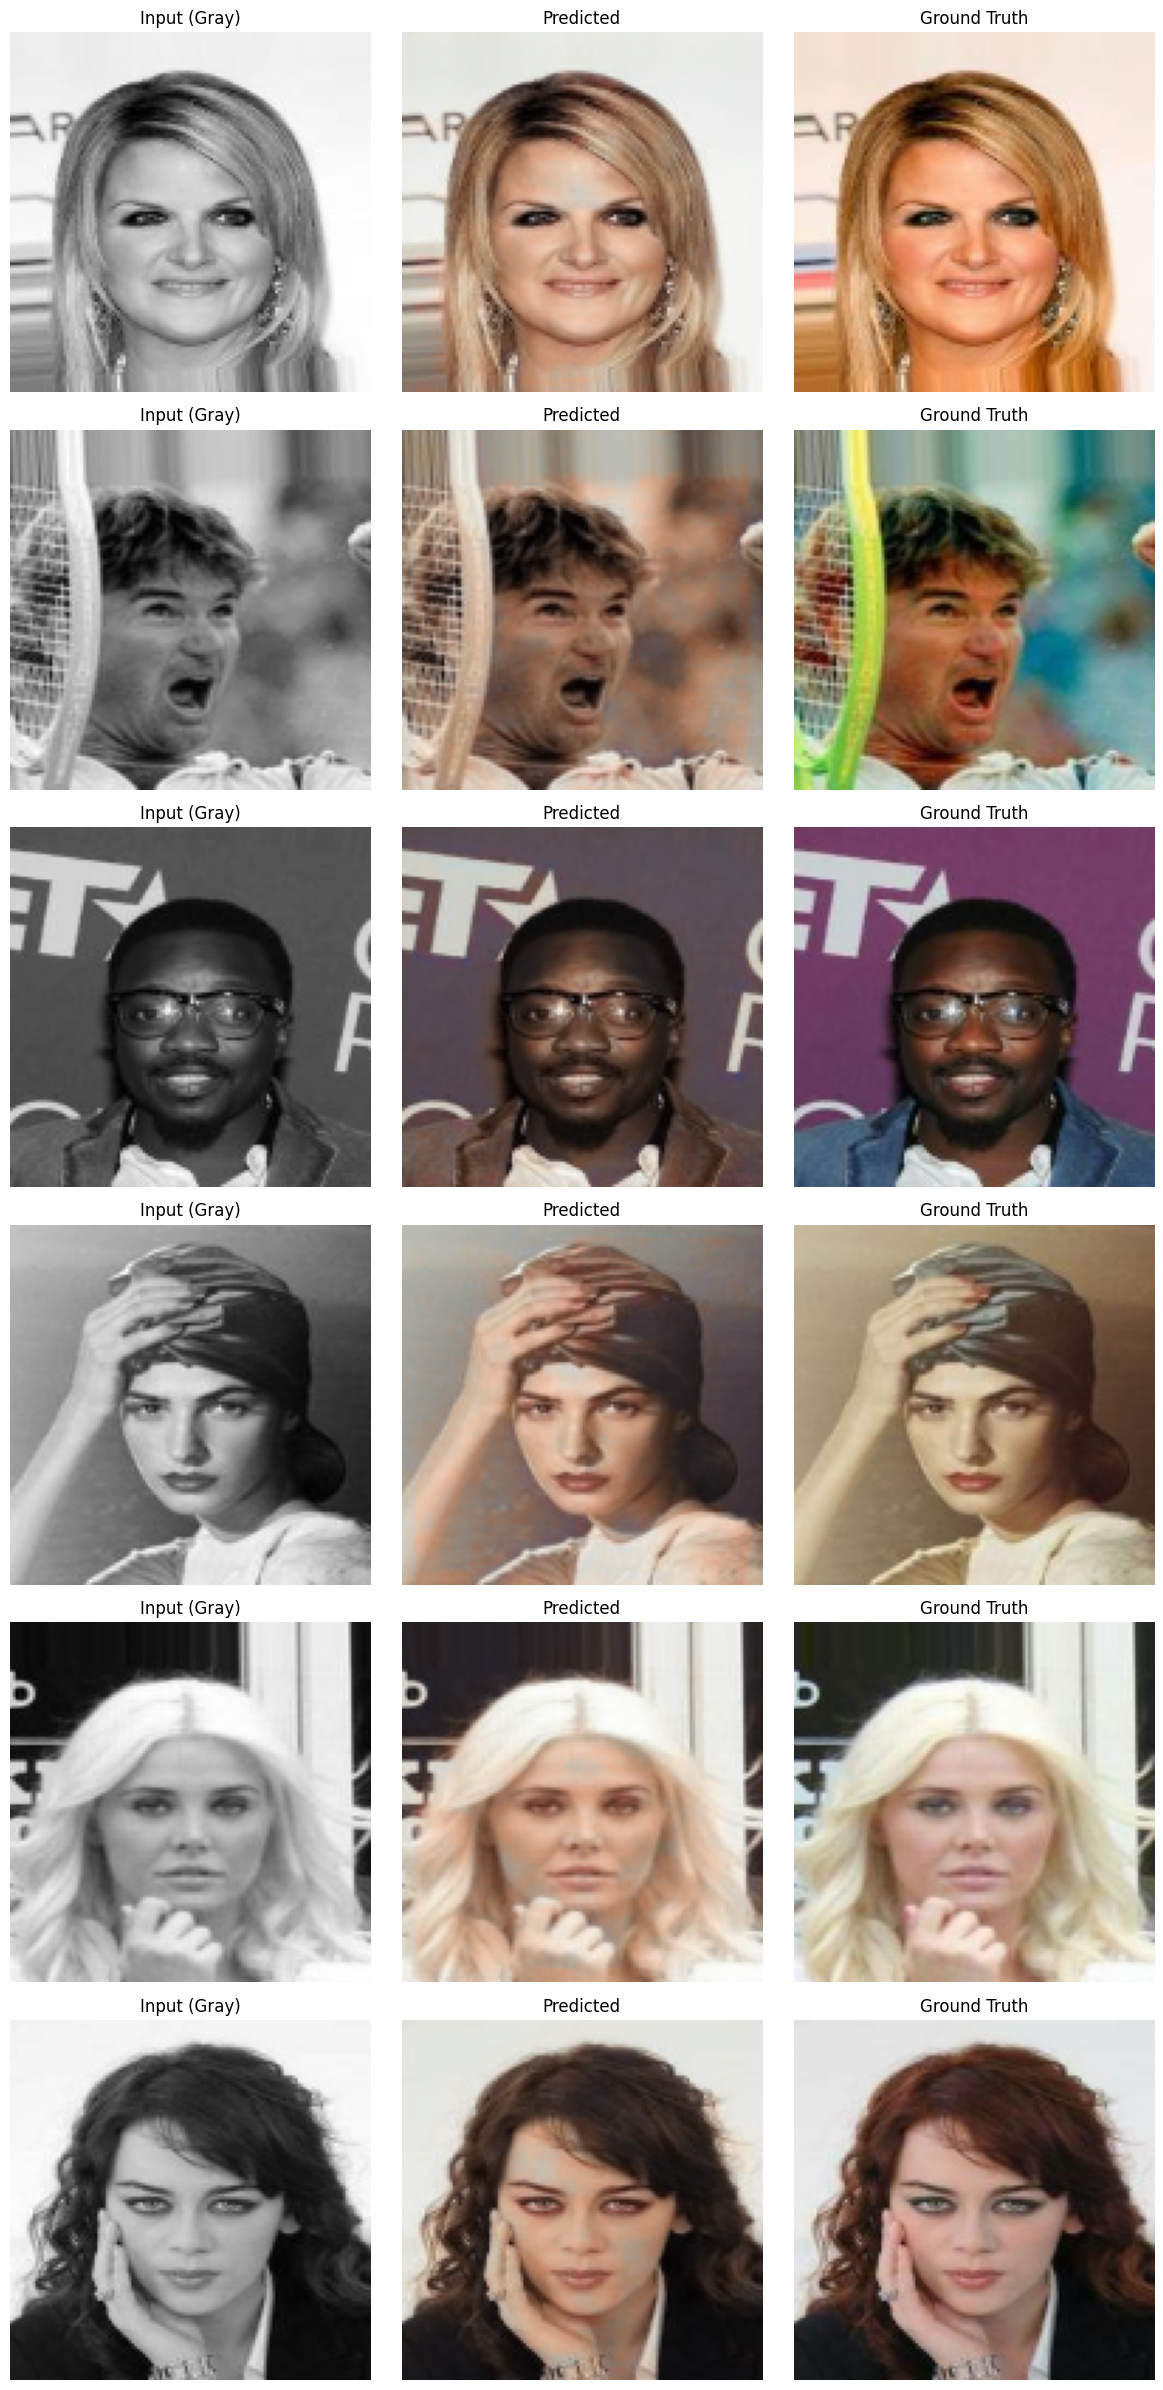

In [10]:
import os, random
import tensorflow as tf
import matplotlib.pyplot as plt

# pick N random images
N_SHOW = 6
all_files = tf.io.gfile.glob(os.path.join(DATA_DIR, "*.jpg"))
random.seed(42)
sample_paths = random.sample(all_files, k=min(N_SHOW, len(all_files)))

# build a batch (X gray, Y real)
x_list, y_list = [], []
for p in sample_paths:
    x, y = load_make_xy(p)   # uses your existing function
    x_list.append(x)
    y_list.append(y)

X_vis = tf.stack(x_list, axis=0)   # (N, H, W, 1)
Y_vis = tf.stack(y_list, axis=0)   # (N, H, W, 3)

# predict
Y_pred = model.predict(X_vis, verbose=0)
Y_pred = tf.clip_by_value(Y_pred, 0.0, 1.0)

# plot: Gray | Pred | Real
plt.figure(figsize=(12, 4 * N_SHOW))

for i in range(len(sample_paths)):
    gray = tf.squeeze(X_vis[i], axis=-1)
    pred = Y_pred[i]
    real = Y_vis[i]

    plt.subplot(len(sample_paths), 3, i*3 + 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Input (Gray)")
    plt.axis("off")

    plt.subplot(len(sample_paths), 3, i*3 + 2)
    plt.imshow(pred)
    plt.title("Predicted")
    plt.axis("off")

    plt.subplot(len(sample_paths), 3, i*3 + 3)
    plt.imshow(real)
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()

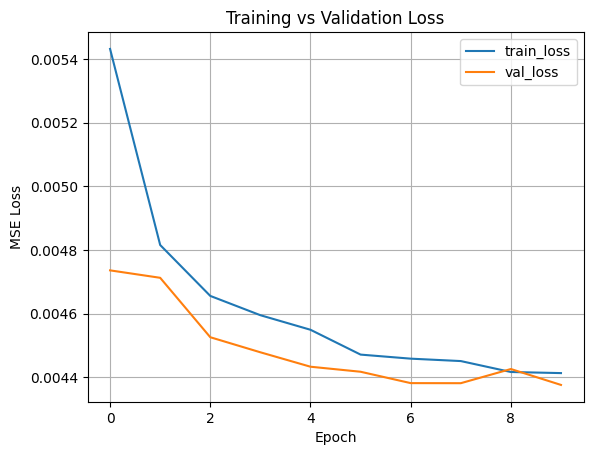

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()